In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import blimpy as bl 
import setigen as stg 
from astropy import units as u
from astropy.coordinates import Angle
import time
import os

%matplotlib inline

In [2]:
carmen_df = pd.read_csv('/home/cgchoza/galaxies/complete_cadences_catalog.csv')
carmen_df['.h5 path'] = carmen_df['.h5 path'].str.replace('0000.h5', '0002.h5', regex=False)
carmen_df = carmen_df.drop_duplicates(subset='.h5 path', keep='first').reset_index(drop=True)
carmen_df = carmen_df[~carmen_df['.h5 path'].str.contains('spliced')].reset_index(drop=True)
carmen_df = carmen_df.drop(index = 17546)

Coarse block shape: (279, 1024)


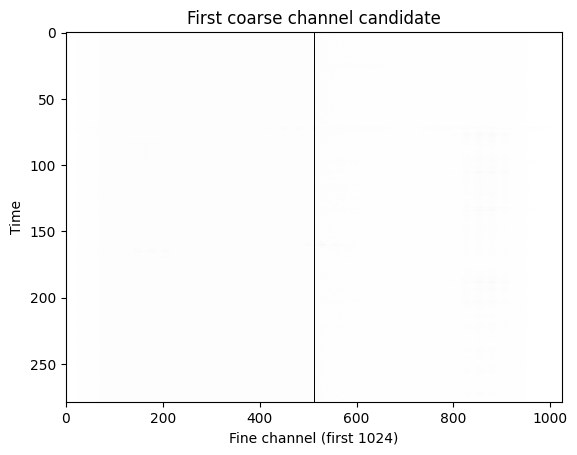

In [3]:
path = carmen_df['.h5 path'].iloc[-1]
data = bl.Waterfall(path, load_data=True).data.squeeze()
coarse_block = data[:, :1024]
print("Coarse block shape:", coarse_block.shape)

# Optional: plot the block to inspect it
import matplotlib.pyplot as plt
plt.imshow(coarse_block, aspect='auto', cmap='Greys', interpolation='none')
plt.xlabel("Fine channel (first 1024)")
plt.ylabel("Time")
plt.title("First coarse channel candidate")
plt.show()


In [4]:
data.shape

(279, 65536)

In [5]:
### Load in single-channel Voyager 1 data to compute some GBT noise statistics.
### If you're using a different telescope, you may wish to load a different HDF5 file for waterfall_fn.

waterfall_fn = carmen_df['.h5 path'].iloc[-1]

fb = bl.Waterfall(waterfall_fn)
print(fb.header)

### Perform a sigma-clipping routine to remove the Voyager signal and most of the PFB rolloff.
### (See C. Choza et al 2024 for justification.)
from astropy.stats import sigma_clip
clipped_data = sigma_clip(fb.data,
                                  sigma=3,
                                  maxiters=5,
                                  masked=False)
### Compute the noise floor and rms. We will use the noise floor to initialize our synthetic frame below.
noise_mean = np.mean(clipped_data)
noise_std = np.std(clipped_data)
print(noise_mean)
print(noise_std)
print(noise_std/noise_mean/np.sqrt(1465))

{'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 1126.46484375, 'foff': -0.00286102294921875, 'ibeam': 1, 'machine_id': 20, 'nbeams': 1, 'nbits': 32, 'nchans': 65536, 'nfpc': 1024, 'nifs': 1, 'rawdatafile': 'guppi_59902_24005_HIP50744_0057.0000.raw', 'source_name': 'HIP50744', 'src_dej': <Angle 21.3908 deg>, 'src_raj': <Angle 10.36250667 hourangle>, 'telescope_id': 6, 'tsamp': 1.073741823999999, 'tstart': 59902.27783564815, 'za_start': 0.0}
740.641
139.55988
0.00492304730969045


In [6]:
### Load in single-channel Voyager 1 data to compute some GBT noise statistics.
### If you're using a different telescope, you may wish to load a different HDF5 file for waterfall_fn.

waterfall_fn = carmen_df['.h5 path'].iloc[20000]

fb = bl.Waterfall(waterfall_fn)
print(fb.header)

### Perform a sigma-clipping routine to remove the Voyager signal and most of the PFB rolloff.
### (See C. Choza et al 2024 for justification.)
from astropy.stats import sigma_clip
clipped_data = sigma_clip(fb.data,
                                  sigma=3,
                                  maxiters=5,
                                  masked=False)
### Compute the noise floor and rms. We will use the noise floor to initialize our synthetic frame below.
noise_mean = np.mean(clipped_data)
noise_std = np.std(clipped_data)
print(noise_mean)
print(noise_std)
print(noise_std/noise_mean/np.sqrt(1465))

{'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 9563.96484375, 'foff': -0.00286102294921875, 'ibeam': -1, 'machine_id': 20, 'nbeams': 1, 'nbits': 32, 'nchans': 65536, 'nifs': 1, 'rawdatafile': 'guppi_59411_52310_HIP7464_0088.0000.raw', 'source_name': 'HIP7464', 'src_dej': <Angle -6.27172194 deg>, 'src_raj': <Angle 1.60250528 hourangle>, 'telescope_id': 6, 'tsamp': 1.073741823999999, 'tstart': 59411.60543981481, 'za_start': 0.0}
243978.55
26744.094
0.0028638972098974868


In [7]:
print(waterfall_fn)

/datag/pipeline/AGBT21A_996_49/blc13/blc13_guppi_59411_52310_HIP7464_0088.rawspec.0002.h5


In [8]:
### We need our synthetic data to be readable by turboSETI/BLISS, so we will make it into an HDF5 file with BL's usual header style.
### Most of this information is a placeholder with the precise value being unimportant.

head = {'DIMENSION_LABELS': np.array([b'time', b'feed_id', b'frequency'], dtype=object), 
        'az_start': 0.0, 
        'data_type': 1, 
        'fch1': fb.header['fch1'], # This is the edge of a C-band node; it can be changed, but other values below will then also have to be changed.
        'foff': fb.header['foff'], # Fine-channel frequency resolution.
        'machine_id': 20, 
        'nbits': 32, 
        'nchans': 65536*16, # 64 or 16??
        'nifs': 1, 
        'source_name': 'synthetic', # Placeholder name. Some Blimpy functions care about the source name.
        'src_dej': Angle(0*u.deg), # Placeholder declination.
        'src_raj': Angle('0h0m0s'), # Placeholder RA.
        'telescope_id': 6, 
        'tsamp': 1.073741823999999, # Time resolution.
        'tstart': 60000, # Arbitrary epoch of observation.
        'za_start': 0.0}

In [9]:
### In this cell, we generate 16 coarse channels' worth of chi2 noise using the noise mean we computed from the real GBT data above.

### Read in the polyphase filterbank (PFB) shape. 
### If you're using a different telescope, you can generate a custom PFB shape using BLISS.
### Type the following command in the terminal on the Berkeley Data Center to see how:
### bliss_generate_channelizer_response -h
long_data = []
n_fine = 1024
n_tap = 8
output_file = "/datax/scratch/jliang/channelizer_response.f32"

cmd = f"bliss_generate_channelizer_response -M 512 -N 12 -f 1024 -o {output_file}"
os.system(cmd)
pfb = np.fromfile(output_file, dtype='float32')

### Do one coarse channel at a time.
### Setigen frame construction has a nonlinear complexity, so this is faster than doing a single frame with 16 channels.
for i in range(16):

    print(i)

    fchans = 1024
    tchans = 279
    df = abs(fb.header['foff'])*1e6*u.Hz
    dt = fb.header['tsamp']*u.s
    fch1 = 6095.214842353016*u.MHz

    frame = stg.Frame(fchans=fchans,
                    tchans=tchans,
                    df=df,
                    dt=dt,
                    fch1=fch1,
                    chi2_df=2)
    noise = frame.add_noise(x_mean=noise_mean)

    
    pfb_data = np.array([spec*pfb for spec in frame.data])

    long_data.append(pfb_data)

Found a usable device
Found a usable device
Found a usable device
Found a usable device
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [10]:
### Stack your 16 coarse channels together into a single array.

concat_long_data = np.hstack(long_data)

In [11]:
### Save your 16 coarse channels of noise as a numpy array. 
### (Replace /datax/scratch/benjb/... with your own scratch directory and filepath.)
### This step is optional -- below we'll also save the array as an HDF5 file.

np.save('/datax/scratch/jliang/test.npy', concat_long_data)

In [12]:
### Convert your 16-channel numpy array back to a setigen Frame.
### Remember to use the metadata we defined earlier!

frame = stg.Frame.from_data(df = abs(fb.header['foff'])*1e6*u.Hz,
                            dt = fb.header['tsamp']*u.s,
                            fch1 = 6095.214842353016*u.MHz,
                            ascending=False,
                            data=concat_long_data,
                            metadata=head)

In [13]:
### Save the 16 channels of noise as an HDF5 file.
### (Replace /datax/scratch/benjb/... with your own scratch directory and filepath.)

frame.save_h5('/datax/scratch/jliang/test.h5')

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/jliang/test.h5 without blobbing.


hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 0.15sec


In [14]:
### Read the noise file back in as a Waterfall object to check that everything looks right.

fb = bl.Waterfall('/datax/scratch/jliang/test.h5')
fb.info()


--- File Info ---
DIMENSION_LABELS :   ['time' 'feed_id' 'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :            6095.214842353015 MHz
            foff :         -0.00286102294921875 MHz
           ibeam :                               -1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                            16384
            nifs :                                1
     rawdatafile :                        Synthetic
     source_name :                        Synthetic
         src_dej :                     -28:22:59.16
         src_raj :                         17:47:15
    telescope_id :                                6
           tsamp :                1.073741823999999
   tstart (ISOT) :          2018-12-13T17:12:37.000
    tstart (MJD) :               58465.717094

In [15]:
### Now we'll start injecting signals.

### Define here the frequencies at which you want to inject signals.
### I put them 32 kHz apart over the full frequency range, which results in 1465 signals.
### You can put them somewhat closer together than this, but if you cram too many signals into
### the data, it biases the noise calculations of turboSETI and BLISS.
### Leave at least 8 kHz of space between, as a general rule.
center_frequencies = np.arange(6048.342703375964+0.008, 6095.214842353015-0.008, 0.032)

n_inj = len(center_frequencies)
print(n_inj)

### Shuffle around the center frequencies by up to +/-50 Hz; this step isn't necessary with fully synthetic data,
### but in RFI-heavy data it helps you ensure that your injections don't line up with RFI combs with the same frequency intervals.
### (Unlikely but possible.)
cf_offsets = np.random.uniform(-0.00005, 0.00005, n_inj)
center_frequencies = center_frequencies + cf_offsets

fdiffs = np.diff(np.sort(center_frequencies))

### Define range of drift rates (in Hz/s).
drift_rates = np.random.uniform(-1, 1, n_inj)

### Define range of SNRs.
snrs = np.random.uniform(1, 1000, n_inj)

### Define signal widths (all unresolved signals in this case).
widths = np.ones_like(snrs)

print(np.min(fdiffs)*1000000)
print(len(center_frequencies))

1465
31901.24584853038
1465


In [18]:
print(drift_rates)

[-0.80708473  0.02469323 -0.4234347  ...  0.36106144  0.68197954
 -0.83748636]


In [19]:
print(lb)
print(rb)

6048.350374612035
6048.350816737456


In [21]:
### In this cell, we'll do the injections using the parameters we defined in the last cell.

freqs, _ = fb.grab_data()

h5_path = '/datax/scratch/jliang/test.h5'
fb = bl.Waterfall('/datax/scratch/jliang/test.h5')
fb.info()

n_coarse = 16
pfb_corr = np.concatenate([np.fromfile('/datax/scratch/jliang/test.h5', dtype='float32') for i in range(n_coarse)])
c = stg.Frame(fb)

intensity = c.get_intensity(snr=1000)

### Loop over all the frequencies — each frequency is a signal.

for i in range(len(center_frequencies)):
    if i%1 == 0:
        print(f'{i} of {len(center_frequencies)}')

    # Retrieve parameters for this signal.
    f = center_frequencies[i]
    d = drift_rates[i]
    w = widths[i]
    s = snrs[i]
    dsign = np.sign(d)

    # Define a bounding box for this signal.
    # The mins and maxes are to account for fch1 sometimes being the leftmost and sometimes the rightmost frequency.

    lb = np.min(((f-dsign*0.0001), (f+d*(1e-6)*300+dsign*0.0001)))
    rb = np.max(((f-dsign*0.0001), (f+d*(1e-6)*300+dsign*0.0001)))

    ### Noise statistics should be calculated solely from the window of injection, not the whole coarse channel.
    data_window = bl.Waterfall(h5_path, lb, rb)
    subc = stg.Frame(data_window)
    # noise_floor = np.mean(data_window)
    # intensity_diff = noise_mean - noise_floor
    # print(noise_mean)
    # print(noise_floor)
    # print(intensity_diff)
    # print(c.get_intensity(snr=1000))
    #print(f'lb: {lb} rb: {rb}')

    c.add_signal(path = stg.constant_path(f_start=(f*u.MHz),
                               drift_rate=d*u.Hz/u.s),
                           t_profile = stg.constant_t_profile(level=subc.get_intensity(snr=s)),
                           f_profile = stg.box_f_profile(width=w*c.df*u.Hz),
                           bp_profile = pfb_corr[np.argmin(np.abs(freqs-rb)):np.argmin(np.abs(freqs-lb))],
                           #stg.constant_bp_profile(level=1),
                           #integrate_t_profile=True,
                           #integrate_f_profile=True,
                           #integrate_path=True,
                           doppler_smearing=True,
                           smearing_subsamples=15,
                           bounding_f_range=(lb*u.MHz, rb*u.MHz))
    
# Convert the Frame to a numpy array and then to a Waterfall object.
# This lets us stipulate the dtype of the array, which keeps seticore from complaining.

fb_new = bl.Waterfall(filename=None, header_dict=fb.header, data_array=np.expand_dims(np.flip(c.data, axis=1), axis=1).astype('<f4'))

fb_new.write_to_hdf5('/datax/scratch/jliang/test_signal.h5')


--- File Info ---
DIMENSION_LABELS :   ['time' 'feed_id' 'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :            6095.214842353015 MHz
            foff :         -0.00286102294921875 MHz
           ibeam :                               -1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                            16384
            nifs :                                1
     rawdatafile :                        Synthetic
     source_name :                        Synthetic
         src_dej :                     -28:22:59.16
         src_raj :                         17:47:15
    telescope_id :                                6
           tsamp :                1.073741823999999
   tstart (ISOT) :          2018-12-13T17:12:37.000
    tstart (MJD) :               58465.717094

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
### Don't forget to save the parameters you generated!

np.save('/datax/scratch/jliang/injections.npy', np.array([center_frequencies, drift_rates, snrs, widths]))